Google Drive to Dropbox YOLO Pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics dropbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.1/572.1 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
import os
import numpy as np
import torch
import cv2
import dropbox
from google.colab import userdata

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
threshold_conf= 0.80
DBX_TOKEN = userdata.get('DB_TOKEN') # will retrieve the Dropbox token from Colab user secrets
##############################################
# Helper functions
def upload_dataset_to_dropbox(dataset_name, dbx_access_token, dataset_type="drivable_area"):
    dbx = dropbox.Dropbox(dbx_access_token)
    dbx_dataset_dir = f'/UMARV/ComputerVision/ScenePerception/datasets/{dataset_name}'
    local_data_dir = f'/content/{dataset_name}/data'
    local_label_dir = f'/content/{dataset_name}/label'
    print(os.listdir(local_label_dir))

    # Iterate over data in the directory and upload each one
    for filename in os.listdir(local_data_dir):
        file_path = os.path.join(local_data_dir, filename)
        dropbox_path = f"{dbx_dataset_dir}/data/{filename}"  # Path in Dropbox

        if os.path.isfile(file_path):
            with open(file_path, 'rb') as file:
                dbx.files_upload(file.read(), dropbox_path, mode=dropbox.files.WriteMode("overwrite"))
            print(f"Uploaded {filename} to Dropbox.")

    # Iterate over labels in the directory and upload each one
    for filename in os.listdir(local_label_dir):
        print(filename)
        file_path = os.path.join(local_label_dir, filename)
        dropbox_path = f"{dbx_dataset_dir}/label/{dataset_type}/{filename}"  # Path in Dropbox

        # Ensure it's a file before trying to open it
        if os.path.isfile(file_path):
            with open(file_path, 'rb') as file:
                dbx.files_upload(file.read(), dropbox_path, mode=dropbox.files.WriteMode("overwrite"))
            print(f"Uploaded {filename} to Dropbox.")

def mp4_to_images(video_path, output_dir, prefix='frame_', image_format='jpg'):
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    # Open video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return

    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        # Construct filename
        frame_filename = os.path.join(output_dir, f"{prefix}{frame_count:06d}.{image_format}")

        # Save frame as image
        cv2.imwrite(frame_filename, frame)

        frame_count += 1

        # # limiting number of frames to 100 for testing; TODO: Remove this later
        # if frame_count >= 100:
        #   break
        if frame_count%100 == 0:
          print(frame_count)

    # Release resources
    cap.release()
    print(f"Extraction complete! {frame_count} frames saved to {output_dir}")

def get_label(result):
    masks = result.masks.data
    # Sum the masks and use a threshold to create a binary mask
    combined_mask = torch.sum(masks, dim=0) > 0

    # combined_mask is a tensor
    return combined_mask.cpu().numpy().astype(np.float32)

def get_img(result):
    # TODO: modify dimensions of the image to fit the model
    return result.orig_img
##############################################
# Pipeline function
def run_pipeline(model_wts_path, video_path, img_dataset_path):
    model = YOLO(model_wts_path)

    _ = mp4_to_images(video_path, img_dataset_path)
    print(f"images saved to {img_dataset_path}")

    results = model(img_dataset_path, stream=True)
    new_train_imgs = []
    new_train_lbls = []

    for result in results:
        if np.mean(result.boxes.conf.cpu().numpy()) > threshold_conf:
            new_train_imgs.append(get_img(result))
            new_train_lbls.append(get_label(result))

    # save new training images and labels to "YOLO_soft_labeled_data" folder
    os.makedirs("YOLO_soft_labeled_data", exist_ok=True)
    data_dir, label_dir = "YOLO_soft_labeled_data/data", "YOLO_soft_labeled_data/label"
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)
    for i, (img, lbl) in enumerate(zip(new_train_imgs, new_train_lbls)):
        idx_str = str(i).zfill(6)
        plt.imsave(f"{data_dir}/{idx_str}.jpg", img)
        plt.imsave(f"{label_dir}/{idx_str}.jpg", lbl, cmap='gray', vmin=0, vmax=1)
        print(f"{label_dir}/{idx_str}.jpg saved")
    print(f"data saved locally in {data_dir}")

    upload_dataset_to_dropbox("YOLO_soft_labeled_data", DBX_TOKEN)
    print("dataset uploaded to dropbox")


In [ ]:
upload_dataset_to_dropbox("YOLO_soft_labeled_data", "sl.u.AFmQbsHjbW1LnFZr_typmtd6uOEHUa3QtWYvdGPt9wQG7utwg1JbsgYEvGpLESPzwwC_yEfLb_U-lObNUtHr4Ngvl9cfXAJEzOWHGuIlC6qRDDoIfz7fRojXv6zAUqjrhQnXDg2JjTDOtmDjZWcbCdhAb3u70QSlbaq3o9oY2RfhjbAkccJwgAp9Rn0f26PXkrtMz2lHtUS1AxpnF3Q5tFIAntNwsZNWphemTeqMCT4DWpKZfiy3d8h8Z3WQKXGhgfoCfKBZ5ze4PubFXSh20nd5B5i7NtlUYU809vZpTHtRa3jRGdRlf6D_WKsFo1cRoRjOy6ZPreeCE4gydgUeMB_bEhtqPOl-tOfLHMSIJZpImfMqsi-2Z5yB_oydsruiA3o0bRhQMKezYT5Kb7QOSGm1A1PgOo71ITKGSNYZQ1TOW1grbQW9VAvJmVmQAEHm_JqkezIBtmeqeGNfCLQuvm66UtjAk8d4760zbt9u3jNapFFmDNvsaIXH8Y4uV-9_gvHHLBYSuRoxkSZWHWGC6-Y52uWSrULUr-lW4Az3Zvz3NkZFJhsqhcIuE-i5u3FQmnRZLQ4QSPq9ChXoTvXVqiNOvLPEffeJ6AzDBThyTvP9imWH_CTQwrCQjf5gMYsfxmfUt_7BrK2hPxVwk3kBJFKASckZIsog_IrGQI4c0zA5AROOVau8t_5nTn6NijQKJuyPKMh34Warxjvoa2A-pYBQuxlK3Mq6SitwOY-HZkRA0Yxk4J5_Txx3CxT3g9xDNcRySe8TAmzWIbI7lLnX0fU5UZxvBGhufgq9SM6_MNvhUCC-8xq6po8vNl4H2mNBrTha5-pYMAWddWub--BLL8ByCatzKDvS6mxDOHgrsbsFrh3xqOrWPWd2vF0PL4RbNrPBDSS9IuAegumbz9OL_Sojc7MuUXPbN9VSvh1JIUBTjiXVUSfbCYbRqbHMS0m8iDwTAqmJWgqsKkwZSAgUQSk7qfaWyME9ICLRuIC2HtH5fGN0o3GswFLmF8H17QDsQpJLnS4katrzYId36vWxw2CUY3_eHYPnLjhT2Xja_4Cd8fmZC9aksPeLimbWCKiDiroqMW6L2JIP3-JIO79ENb-kHj5uzfTPJjz0MlHlkJJuJmkDZr_WADaFVOP1s_X8Vt5vHhZmSf6bNCXBCgpFGioQhJ67fdYmLYU3wNJz9TRfWZVr18l2ko7pMzUNifdkIzUeywSkKWBzpTmY2uGT0vJLi5ynubSFExKaAaPl8IKJNk8iVj1_OuXQiJcD857lRBs63gunZUnl09sUNenIOrOroFO74r_ZFADArzbESnOkdwsQogBVqOM33JET08y8s0fOQ_QjchgCm-db9wcy0lZ0c0ZuI_V93nY3MfeacH-XPstGf26FWFNgS7tn-jSDlgyg-MLrJFTbD6qSEUWoUeAjM80bu-SxocJ_h-4ADY0KIPB3oxy0pCxj5C-oLiqvYJY")

['000223.jpg', '000663.jpg', '001117.jpg', '001077.jpg', '001201.jpg', '001089.jpg', '001895.jpg', '000284.jpg', '001145.jpg', '002102.jpg', '002060.jpg', '000961.jpg', '001567.jpg', '000846.jpg', '001210.jpg', '001311.jpg', '000263.jpg', '001580.jpg', '001147.jpg', '000052.jpg', '000091.jpg', '001968.jpg', '000130.jpg', '000183.jpg', '001539.jpg', '000161.jpg', '001972.jpg', '001494.jpg', '001141.jpg', '002163.jpg', '001066.jpg', '001106.jpg', '001020.jpg', '001813.jpg', '000624.jpg', '000252.jpg', '000924.jpg', '000156.jpg', '000921.jpg', '000842.jpg', '000482.jpg', '001044.jpg', '001922.jpg', '002365.jpg', '002343.jpg', '001951.jpg', '000983.jpg', '000120.jpg', '002398.jpg', '000199.jpg', '001677.jpg', '000178.jpg', '000386.jpg', '000761.jpg', '000880.jpg', '000940.jpg', '001374.jpg', '002047.jpg', '000326.jpg', '000914.jpg', '002349.jpg', '001915.jpg', '002237.jpg', '001530.jpg', '000422.jpg', '000471.jpg', '000829.jpg', '000235.jpg', '000925.jpg', '001057.jpg', '000356.jpg', '0017

In [ ]:
# Main Function

def main():
  # Modify paths as required
  video_path = "/content/drive/Shareddrives/STUDENT-Robotics | UMARV/2024 - 2025/Computer Vision/videos/comp23_2 (1).mp4"
  model_path = "/content/drive/Shareddrives/STUDENT-Robotics | UMARV/2024 - 2025/Computer Vision/Current Best model/Potholes and Driveable Area seperated/bestDriveableArea.pt"
  img_dataset_path = "/content/drive/Shareddrives/STUDENT-Robotics | UMARV/2024 - 2025/Computer Vision/YOLO_test_data"
  run_pipeline(model_path, video_path, img_dataset_path)

main()

Streaming output truncated to the last 5000 lines.
image 335/2824 /content/drive/Shareddrives/STUDENT-Robotics | UMARV/2024 - 2025/Computer Vision/YOLO_test_data/frame_000334.jpg: 384x640 1 driveable, 10.6ms
image 336/2824 /content/drive/Shareddrives/STUDENT-Robotics | UMARV/2024 - 2025/Computer Vision/YOLO_test_data/frame_000335.jpg: 384x640 1 driveable, 10.6ms
image 337/2824 /content/drive/Shareddrives/STUDENT-Robotics | UMARV/2024 - 2025/Computer Vision/YOLO_test_data/frame_000336.jpg: 384x640 1 driveable, 10.6ms
image 338/2824 /content/drive/Shareddrives/STUDENT-Robotics | UMARV/2024 - 2025/Computer Vision/YOLO_test_data/frame_000337.jpg: 384x640 1 driveable, 10.7ms
image 339/2824 /content/drive/Shareddrives/STUDENT-Robotics | UMARV/2024 - 2025/Computer Vision/YOLO_test_data/frame_000338.jpg: 384x640 1 driveable, 10.6ms
image 340/2824 /content/drive/Shareddrives/STUDENT-Robotics | UMARV/2024 - 2025/Computer Vision/YOLO_test_data/frame_000339.jpg: 384x640 1 driveable, 10.6ms
image 3

AuthError: AuthError('909ed31e8fbc4506a0ed5ee8e6eecde0', AuthError('expired_access_token', None))

Import Libraries

In [ ]:
import os
import sys
from getpass import getpass
import torch.optim as optim
!pip install dropbox > /dev/null

Configure Environment

In [ ]:
os.environ["ENVIRONMENT"] = "colab"
os.environ["REPO_DIR"] = "/content/UMARV-CV-ScenePerception"
os.environ["ROOT_DIR"] = "/content"
os.environ["MODEL_ID"] = "32offjns"
os.environ["MODEL_DIR"] = f"{os.getenv('REPO_DIR')}/models/model_{os.getenv('MODEL_ID')}"

Configure git

In [ ]:
# Fill in branch
git_branch = "SemiSupervisedLearning"

while not git_branch:
    git_branch = input("Enter your branch: ")

git_repo_url = "https://github.com/umigv/UMARV-CV-ScenePerception.git"
!git clone -b $git_branch $git_repo_url
%cd "{os.getenv('REPO_DIR')}"

Cloning into 'UMARV-CV-ScenePerception'...
remote: Enumerating objects: 3772, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 3772 (delta 20), reused 16 (delta 14), pack-reused 3737 (from 1)
Receiving objects: 100% (3772/3772), 206.48 MiB | 20.42 MiB/s, done.
Resolving deltas: 100% (1184/1184), done.
Updating files: 100% (278/278), done.
/content/UMARV-CV-ScenePerception


In [ ]:
!git pull

Already up to date.


Import Repository Resources

In [ ]:
sys.path.insert(0, f"{os.getenv('REPO_DIR')}/src/scripts")
from helpers import *

sys.path.insert(0, f"{os.getenv('MODEL_DIR')}/src")
from methods import *
from architecture import *
from dataset import *

Download Datasets

In [ ]:
dbx_access_token = getpass("Enter your DropBox access token: ")

Enter your DropBox access token: ··········


In [ ]:
download_datasets_from_dropbox(
    dbx_access_token = dbx_access_token,
    include_all_datasets = False,
    use_thread = True,
    datasets=["YOLO_soft_labeled_data"]
)

# upload_datasets_to_google_drive()

In [ ]:
# get_datasets_from_google_drive()

Code

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
num_epochs = 100
batch_size = 8
val_size = 50

In [ ]:
import gc
gc.collect()

72

In [ ]:
lookback = {'count': 0, 'stride': 0}
device = set_device()
model = initialize_model(device=device, dbx_access_token=dbx_access_token, lookback=lookback)

train_dataset, val_dataset = create_datasets(
    lookback = lookback,
    device = device,
    datasets=["YOLO_soft_labeled_data"]
)

print(train_dataset.dataset_dir)
print(train_dataset.data)

train_dataloader, val_dataloader = create_dataloaders(
    train_dataset = train_dataset,
    val_dataset = val_dataset,
    batch_size = batch_size,
    val_batch_size = val_size
)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

Using GPU!
Downloaded model weights from Dropbox.
/content/datasets
[{'dataset': 'YOLO_soft_labeled_data', 'idx': 179}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 2433}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 152}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 1155}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 2461}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 2407}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 301}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 2064}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 1392}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 1437}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 441}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 586}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 58}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 2018}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 2290}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 2112}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 379}, {'dataset': 'YOLO_soft_labeled_data', 'idx': 2159}, {'d

In [ ]:
model, train_loss_hist, val_performance_hist, best_val_performance = training_loop(
    model = model,
    criterion = criterion,
    optimizer = optimizer,
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    dbx_access_token = dbx_access_token,
    num_epochs = num_epochs,
    critiqueing_metric = "Accuracy",
    auto_stop = False
)

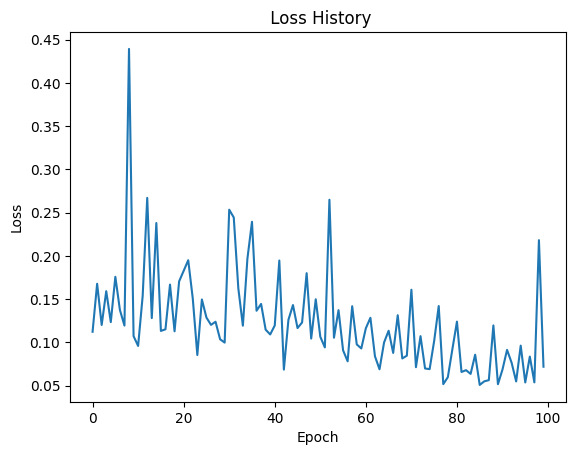

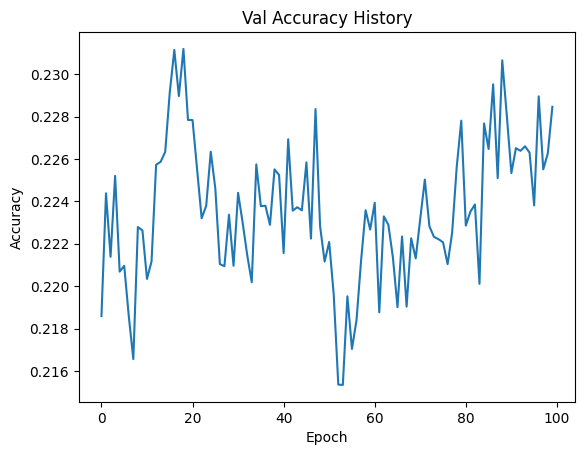

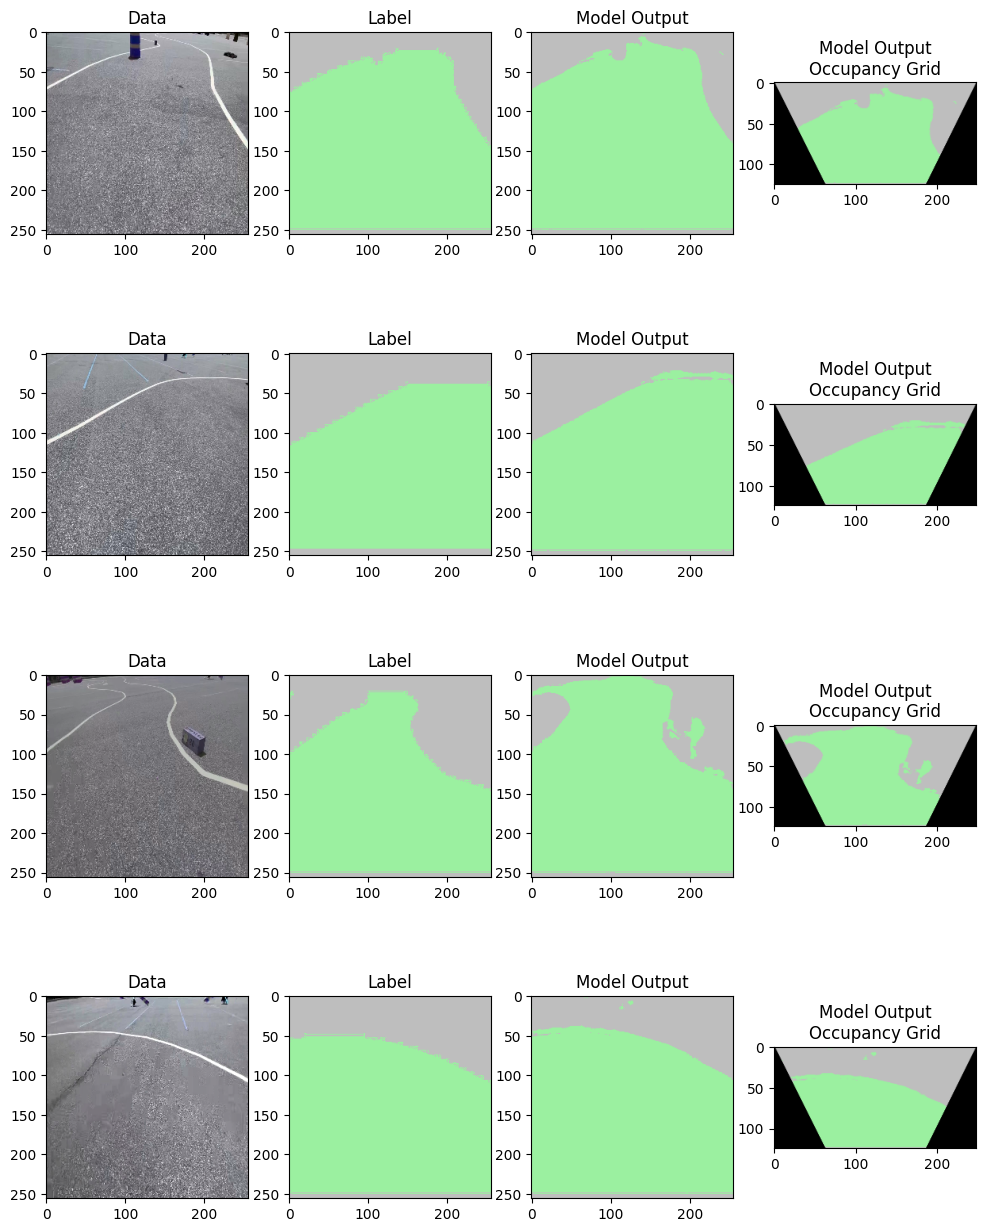

In [ ]:
graph_loss_history(train_loss_hist)

graph_performance_history(
    performance_hist = val_performance_hist,
    split = 'Val',
    metrics = ["Accuracy"]
)

show_sample_results(
    model = model,
    dataset = train_dataset,
    device = device,
)

In [ ]:
test_model_on_benchmarks(
    lookback = {'count': 0, 'stride': 0},
    model = model,
    device = device,
    all_benchmarks = True,
    report_results = True
)

Training Loop Functions (Don't have to use these)

In [ ]:
dataset_path = "/content/YOLO_soft_labeled_data"
images = [os.path.join(dataset_path, img) for img in os.listdir(dataset_path) if img.endswith(('.png'))]
labels = [os.path.join(dataset_path, lbl) for lbl in os.listdir(dataset_path) if lbl.endswith(('.npy'))]
print(sorted(images))

['/content/YOLO_soft_labeled_data/img_0.png', '/content/YOLO_soft_labeled_data/img_1.png', '/content/YOLO_soft_labeled_data/img_10.png', '/content/YOLO_soft_labeled_data/img_11.png', '/content/YOLO_soft_labeled_data/img_12.png', '/content/YOLO_soft_labeled_data/img_13.png', '/content/YOLO_soft_labeled_data/img_14.png', '/content/YOLO_soft_labeled_data/img_15.png', '/content/YOLO_soft_labeled_data/img_16.png', '/content/YOLO_soft_labeled_data/img_17.png', '/content/YOLO_soft_labeled_data/img_18.png', '/content/YOLO_soft_labeled_data/img_19.png', '/content/YOLO_soft_labeled_data/img_2.png', '/content/YOLO_soft_labeled_data/img_20.png', '/content/YOLO_soft_labeled_data/img_21.png', '/content/YOLO_soft_labeled_data/img_22.png', '/content/YOLO_soft_labeled_data/img_23.png', '/content/YOLO_soft_labeled_data/img_24.png', '/content/YOLO_soft_labeled_data/img_25.png', '/content/YOLO_soft_labeled_data/img_26.png', '/content/YOLO_soft_labeled_data/img_27.png', '/content/YOLO_soft_labeled_data/img

In [ ]:
## Training loop functions
def get_acc(model, loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def train(train_loader, val_loader, criterion=torch.nn.CrossEntropyLoss()):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = lane_model(lookback={'count': 3}).to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    # epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if epoch % 10 == 0:
            print(f'Epoch {epoch} loss: {running_loss}')
            print("Train Acc: ", get_acc(model, train_loader))
            print("Val Acc: ", get_acc(model, val_loader))
            print("\n")
    return model

Push Changes (when ready)

In [ ]:
# Fill in user info
git_username = ""
git_email = ""

while not git_username:
    commit_message = input("Username left empty.\nGitHub username: ")
while not git_email:
    commit_message = input("Email left empty.\nGitHub email: ")

!git config --global user.name $git_username
!git config --global user.email $git_email

git_access_token = getpass("Enter your GitHub access token: ")

git_push_url = f"https://{git_username}:{git_access_token}@{git_repo_url.replace('https://','')}"

commit_message = input("Commit message: ")
while not commit_message:
    commit_message = input("Commit message cannot be empty\nCommit message: ")

!git add .
!git commit -m "{commit_message}"
!git push $git_push_url $git_branch